In [1]:
import sys
import os
path = os.path.abspath('../..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import collections
import concurrent.futures
import datetime
import json
import termcolor
import re

import numpy as np

from IPython import display

from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia import components as generic_components
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.utils import html as html_lib
from concordia.utils import measurements as measurements_lib
from concordia.utils import plotting

In [2]:
local_models = True

if local_models:
    # Setup LLM
    from concordia.language_model import ollama_model
    model = ollama_model.OllamaLanguageModel(
        model_name='gemma',
        streaming=True
    )

    # Setup measurements and clock
    measurements = measurements_lib.Measurements()
    time_step = datetime.timedelta(minutes=20)
    SETUP_TIME = datetime.datetime(hour=20, year=2024, month=10, day=1)

    START_TIME = datetime.datetime(hour=18, year=2024, month=10, day=2)
    clock = game_clock.MultiIntervalClock(
        start=SETUP_TIME,
        step_sizes=[time_step, datetime.timedelta(seconds=10)])

    # Setup sentence encoder
    from sentence_transformers import SentenceTransformer
    st5_model = SentenceTransformer('sentence-transformers/sentence-t5-base')
    embedder = st5_model.encode

else:
    from concordia.language_model import gpt_model
    from concordia.language_model import gcloud_model
    # @title Language Model - pick your model and provide keys
    CLOUD_PROJECT_ID = '' #@param {type: 'string'}
    GPT_API_KEY = '' #@param {type: 'string'}
    GPT_MODEL_NAME = '' #@param {type: 'string'}

    USE_CLOUD = True #@param {type: 'boolean'}

    if USE_CLOUD:
        model = gcloud_model.CloudLanguageModel(project_id= CLOUD_PROJECT_ID)
    else:
        model = gpt_model.GptLanguageModel(api_key=GPT_API_KEY, model_name=GPT_MODEL_NAME)

#@title Importance models
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()


In [3]:
# @title Generic memories are memories that all players and GM share.

shared_memories = [
    'Alice returns late from work and finds Dorothy at her doorstep.',
    "Dorothy has to move out of her house tonight and needs someone to help her move.",
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Sure, here is a concise summary of the passage in a concise and insightful fashion:

Alice returns home late from work and finds Dorothy at her doorstep. Dorothy is forced to move out of her house that night and needs assistance with the move.

In [4]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

In [5]:
#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes
NUM_PLAYERS = 2

scenario_premise = [

    (
        'Alice returns late from work and finds her friend Dorothy at her doorstep. '
        + 'Dorothy has to move out of her house tonight and needs someone to help her move.'
    ),
]
player_configs = [
    formative_memories.AgentConfig(
        name='Alice',
        gender='female',
        goal='Alice is exhausted after work, and she needs to help her grandmother all day the next day.',
        context=shared_context,
        traits='responsibility: medium; aggression: medium',
    ),
    formative_memories.AgentConfig(
        name='Dorothy',
        gender='female',
        goal=(
            "Dorothy has planned on Bob helping her move, but Bob didn't show up. "
        ),
        context=shared_context,
        traits='responsibility: medium; aggression: medium',
    ),
]

In [6]:
mem = formative_memory_factory.make_memories(player_configs[0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Alice: A Woman of Balance and Uncertainty

**Job:** Graphic Designer

**Typical Day:**

* Wake up and start early, usually around 8:00 AM.
* Work on freelance projects and client commissions.
* Attend meetings and collaborate with clients.
* Wrap up work by 6:00 PM.
* Commute home, usually by bus.
* Spend time with friends and family.
* Cook and bake, often experimenting with new recipes.
* Read books and articles on various topics.
* Catch up on social media and news.
* Go out for social events and activities.

**Goals:**

* To establish a successful freelance career.
* To build a strong network of clients and collaborators.
* To achieve financial stability and independence.
* To travel the world and experience different cultures.

**Desires:**

* To have a creative outlet that allows her to express herself freely.
* To find love and companionship.
* To be recognized for her talent and hard work.
* To make a positive impact on the world.

**Hopes and Dreams:**

* To have a successf

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Formative Episode at Age 3

Three-year-old Alice, a woman of balance and uncertainty, was returning home late from work one evening. As she approached her doorstep, she found her neighbor, Dorothy, standing there, her belongings scattered about. Seeing Dorothy's distress, Alice knew she had to help. Together, they worked tirelessly to move Dorothy's belongings and get her settled into a new place.

## Formative Episode at Age 7

Seven-year-old Alice, a woman of balance and uncertainty, was returning home late from work one evening. As she approached her doorstep, she found her neighbor, Dorothy, standing there, her belongings scattered about. Seeing Dorothy's distress, Alice knew she had to help. Together, they worked tirelessly to move Dorothy's belongings and get her settled into a new place.

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Formative Episode at Age 12

Twelve-year-old Alice, a woman of balance and uncertainty, was returning home late from work one evening. As she approached her doorstep, she found her neighbor, Dorothy, standing there, her belongings scattered about. Seeing Dorothy's distress, Alice knew she had to help. Together, they worked tirelessly to move Dorothy's belongings and get her settled into a new place.

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Formative Episode at Age 16

Sixteen-year-old Alice, a woman of balance and uncertainty, was returning home late from work one evening. As she approached her doorstep, she found her neighbor, Dorothy, standing there, her belongings scattered about. Seeing Dorothy's distress, Alice knew she had to help. Together, they worked tirelessly to move Dorothy's belongings and get her settled into a new place.

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Formative Episode at Age 21

Twenty-one-year-old Alice, a woman of balance and uncertainty, was returning home late from work one evening. As she approached her doorstep, she found her neighbor, Dorothy, standing there, her belongings scattered about. Seeing Dorothy's distress, Alice knew she had to help. Together, they worked tirelessly to move Dorothy's belongings and get her settled into a new place.

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
%autoreload 2
from examples.custom_components import tpb

behav = tpb.BehavioralChoices(
  "behav",
  model=model,
  memory=mem,
  player_config=player_configs[0],
  clock_now=None,
  num_memories_to_retrieve=100
)

behav.update()

## Alice's Potential Behaviours and Consequences

**Potential Behaviour:** Help Dorothy move her belongings

**Positive Consequences:**

1. Dorothy is grateful for Alice's help and offers her a slice of apple pie. (Value: 8, Likelihood: 80%)
2. Alice feels good knowing she helped someone in need. (Value: 7, Likelihood: 70%)
3. Alice feels accomplished and has a sense of purpose. (Value: 6, Likelihood: 60%)

**Negative Consequences:**

4. Alice is exhausted and has to cancel her plans for the next day. (Value: -2, Likelihood: 40%)
5. Alice has to spend more time moving Dorothy's belongings, delaying her own plans. (Value: -4, Likelihood: 60%)
6. Alice gets frustrated and overwhelmed by the situation. (Value: -6, Likelihood: 20%)

**Potential Behaviour:** Ignore Dorothy and continue on her way

**Positive Consequences:**

1. Alice avoids getting involved in someone else's problems. (Value: 5, Likelihood: 60%)
2. Alice can rest and recover from work. (Value: 4, Likelihood: 50%)
3. Alice h

In [9]:
behav.jsonify()

- 1. Dorothy is grateful for Alice's help and offers her a slice of apple pie. (Value: 8, Likelihood: 80%) -
- 2. Alice feels good knowing she helped someone in need. (Value: 7, Likelihood: 70%) -
- 3. Alice feels accomplished and has a sense of purpose. (Value: 6, Likelihood: 60%) -
- 4. Alice is exhausted and has to cancel her plans for the next day. (Value: -2, Likelihood: 40%) -
- 5. Alice has to spend more time moving Dorothy's belongings, delaying her own plans. (Value: -4, Likelihood: 60%) -
- 6. Alice gets frustrated and overwhelmed by the situation. (Value: -6, Likelihood: 20%) -
- 1. Alice avoids getting involved in someone else's problems. (Value: 5, Likelihood: 60%) -
- 2. Alice can rest and recover from work. (Value: 4, Likelihood: 50%) -
- 3. Alice has more time for her own personal matters. (Value: 3, Likelihood: 40%) -
- 4. Dorothy is upset and feels abandoned. (Value: -3, Likelihood: 30%) -
- 5. Alice feels guilty about not helping. (Value: -5, Likelihood: 40%) -
- 6. 

[{'behaviour': 'Help Dorothy move her belongings',
  'consequences': [{'description': "Dorothy is grateful for Alice's help and offers her a slice of apple pie.",
    'value': 8,
    'likelihood': 0.8},
   {'description': 'Alice feels good knowing she helped someone in need.',
    'value': 7,
    'likelihood': 0.7},
   {'description': 'Alice feels accomplished and has a sense of purpose.',
    'value': 6,
    'likelihood': 0.6},
   {'description': 'Alice is exhausted and has to cancel her plans for the next day.',
    'value': -2,
    'likelihood': 0.4},
   {'description': "Alice has to spend more time moving Dorothy's belongings, delaying her own plans.",
    'value': -4,
    'likelihood': 0.6},
   {'description': 'Alice gets frustrated and overwhelmed by the situation.',
    'value': -6,
    'likelihood': 0.2}]},
 {'behaviour': 'Ignore Dorothy and continue on her way',
  'consequences': [{'description': "Alice avoids getting involved in someone else's problems.",
    'value': 5,
    

In [10]:
%autoreload 2
from examples.custom_components import tpb

people = tpb.SubjectiveNorms(
  "people",
  model=model,
  memory=mem,
  player_config=player_configs[0],
  components=[behav],
  clock_now=None,
  num_memories_to_retrieve=100
)

people.update()

- 1. Dorothy is grateful for Alice's help and offers her a slice of apple pie. (Value: 8, Likelihood: 80%) -
- 2. Alice feels good knowing she helped someone in need. (Value: 7, Likelihood: 70%) -
- 3. Alice feels accomplished and has a sense of purpose. (Value: 6, Likelihood: 60%) -
- 4. Alice is exhausted and has to cancel her plans for the next day. (Value: -2, Likelihood: 40%) -
- 5. Alice has to spend more time moving Dorothy's belongings, delaying her own plans. (Value: -4, Likelihood: 60%) -
- 6. Alice gets frustrated and overwhelmed by the situation. (Value: -6, Likelihood: 20%) -
- 1. Alice avoids getting involved in someone else's problems. (Value: 5, Likelihood: 60%) -
- 2. Alice can rest and recover from work. (Value: 4, Likelihood: 50%) -
- 3. Alice has more time for her own personal matters. (Value: 3, Likelihood: 40%) -
- 4. Dorothy is upset and feels abandoned. (Value: -3, Likelihood: 30%) -
- 5. Alice feels guilty about not helping. (Value: -5, Likelihood: 40%) -
- 6. 

In [12]:
%autoreload 2
from examples.custom_components import tpb

motivs = tpb.PersonMotivations(
  "motivs",
  model=model,
  memory=mem,
  player_config=player_configs[0],
  components=[people],
  clock_now=None
)

motivs.update()

## People and their influence on Alice's actions

**Grandmother:** (Motivation: 60)
Alice is motivated to help her grandmother primarily due to her exhaustion and the need to help her the next day. While she considers her grandmother's approval, she prioritizes her own well-being and exhaustion.

**Friend:** (Motivation: 20)
Alice is less motivated to consider her friend's approval compared to her grandmother. While she may appreciate their support, her primary focus is on her own needs and her grandmother's well-being.

**Neighbor:** (Motivation: 40)
Alice is more concerned with her neighbor's distress than her approval. However, her own exhaustion and the need to help her grandmother may influence her ability to fully help her neighbor.

**Coworker:** (Motivation: 10)
Alice is less motivated to consider her coworker's approval than her other relationships. While she may value their opinion, her primary focus is on her personal well-being and her grandmother's needs.

**Landlord:** (M

In [13]:
json_test = motivs.jsonify()

In [57]:
import scipy.stats as stats
from scipy.special import softmax
import numpy as np

bis = []
sns = []
for i in range(len(json_test)):
  # print(json_test[i]["behaviour"])
  bis.append(sum([item["value"] * item["likelihood"] for item in json_test[i]["consequences"]]))
  sns.append(sum([person["approval"] * person["motivation"] for person in json_test[i]["people"]]))

weight = 0.5
bis = np.asarray(stats.zscore(bis))
sns = np.asarray(stats.zscore(sns))
avs = ((weight * bis) + ((1 - weight) * sns))

all_behavs = [b["behaviour"] for b in json_test]
# print(softmax(bis + sns))

print(avs)


[ 0.78406629 -1.50600248  0.68841077 -0.84939232  0.88291775]


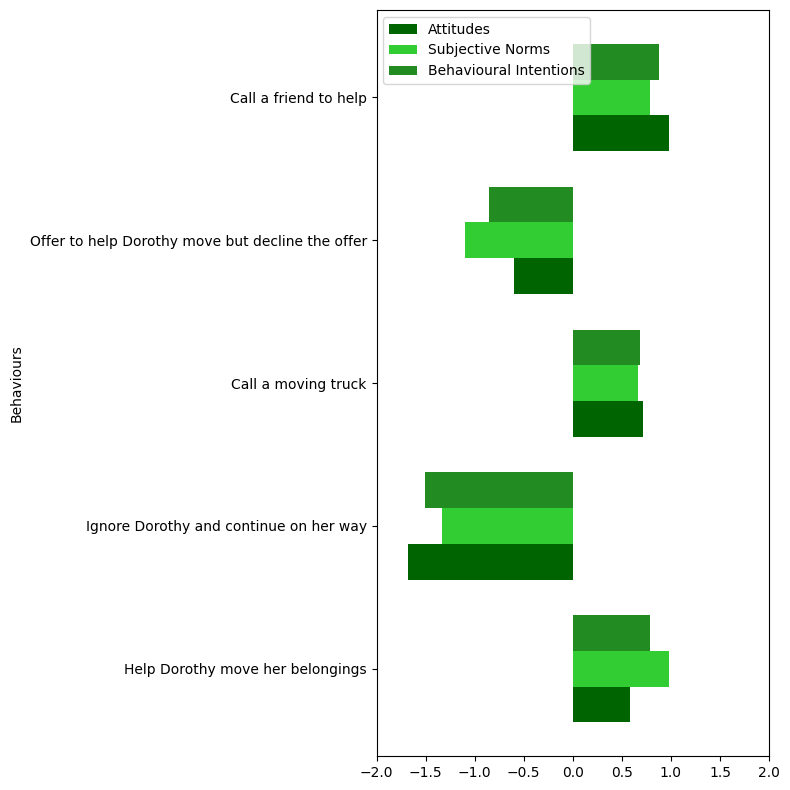

In [58]:
import matplotlib.pyplot as plt

bw = 0.25

b1 = np.arange(len(avs))
b2 = [x + bw for x in b1]
b3 = [x + bw for x in b2]

plt.figure(figsize=(8,8))

plt.barh(b1, bis, height = bw, color = 'darkgreen', label = 'Attitudes')
plt.barh(b2, sns, height = bw, color = 'limegreen', label = 'Subjective Norms')
plt.barh(b3, avs, height = bw, color = 'forestgreen', label = 'Behavioural Intentions')

plt.ylabel('Behaviours')
plt.yticks([x + bw for x in b1], all_behavs)
plt.xlim((-2, 2))
# plt.yticks(rotation=90)
# plt.subplots_adjust(bottom=0.50)
plt.tight_layout()
plt.legend(loc="upper left")
plt.savefig('test.png', dpi = 150)

# plt.show()

5